<h1 style="text-align: center;" markdown="1">TP2: Primer KNN eliminando filas con columnas nulas y regresion</h1>
![](../data/icon_properati-data.png)

In [1]:
import numpy as np 
import pandas as pd

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

# modules
import knn as knnlibrary

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
properties =knnlibrary.get_dataset()
properties.head()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,ecc59daba3d5bc726ae8aa9dbccfe79635aef175,2016-06-01,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0,"-34.5888560251,-58.4087713338",...,130.0,NaN,3461.538462,5.0,4.0,NaN,http://www.properati.com.ar/ys05_venta_departa...,UNIDAD AL FRENTE CON BALCON CORRIDO Y 2 COCHER...,IMPECABLE PISO DE 4 AMB + DEP Y 2 COCHERAS,https://thumbs4.properati.com/2/RbSA4pJRsv2S8M...
1,7f1423f29df530cae38e7a59ddc6430c7da7ca38,2016-06-01,sell,apartment,Once,|Argentina|Capital Federal|Once|,Argentina,Capital Federal,3430291.0,"-34.6033997612,-58.3984088548",...,46.0,NaN,2065.217391,1.0,1.0,NaN,http://www.properati.com.ar/ys06_venta_departa...,SE VENDE A ESTRENAR EN PLENO CORAZON DE ONCE !...,Excelentes oficinas a estrenar!!!!!,https://thumbs4.properati.com/8/IMCZ4CqITeOqx5...
2,4fdd84d998a3f82f4a3b36f405cc3f7013fb642e,2016-06-01,sell,store,Barrio Norte,|Argentina|Capital Federal|Barrio Norte|,Argentina,Capital Federal,3436109.0,"-34.595849,-58.386979",...,0.0,NaN,NaN,NaN,NaN,500.0,http://www.properati.com.ar/ys0r_venta_local_b...,Local en Venta sobre Avenida Santa Fe.Ideal pa...,Local sobre Av. Santa Fe,https://thumbs4.properati.com/9/-VNE04tbyVFfcO...
3,a786b4d9a8f6cc86ba3e839f4cb85bbb03cf15fd,2016-06-01,sell,house,Adrogué,|Argentina|Bs.As. G.B.A. Zona Sur|Almirante Br...,Argentina,Bs.As. G.B.A. Zona Sur,NaN,"-34.796679,-58.3993149",...,0.0,1285.714286,NaN,NaN,6.0,NaN,http://www.properati.com.ar/ys10_venta_casa_ad...,CHALET INMEJORABLE UBICACIÓN: PLANTA BAJA: AMP...,IMPORTANTE CHALET ZONA MUY RESIDENCIAL,https://thumbs4.properati.com/5/FhMeTqvYjAiHVS...
4,9844244d17eb024e0632a63b4098b67889de06bc,2016-06-01,sell,house,Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|,Argentina,Bs.As. G.B.A. Zona Norte,3429979.0,NaN,...,120.0,1250.000000,1250.000000,NaN,4.0,NaN,http://www.properati.com.ar/ys1c_venta_casa_pi...,"Casa muy funcional, desarrollada en una sola p...",BAYUGAR PROPIEDADES/ LINDISIMA CASA/ BARRIO CA...,https://thumbs4.properati.com/2/dxU45Z8wqh3Mdq...


In [3]:
# transformo el campo fecha
properties_caba = knnlibrary.transform_date(properties)

properties_caba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457560 entries, 0 to 80257
Data columns (total 30 columns):
id                            457560 non-null object
created_on                    457560 non-null object
operation                     457560 non-null object
property_type                 457560 non-null object
place_name                    457494 non-null object
place_with_parent_names       457560 non-null object
country_name                  457560 non-null object
state_name                    457560 non-null object
geonames_id                   386355 non-null float64
lat-lon                       334976 non-null object
lat                           334976 non-null float64
lon                           334976 non-null float64
price                         415497 non-null float64
currency                      399083 non-null object
price_aprox_local_currency    415497 non-null float64
price_aprox_usd               415497 non-null float64
surface_total_in_m2           309478

In [4]:
# filtro por CABA y GBA
# queremos solo las propiedades que tienen precio y eliminamos columnas que sabemos que no son 
#redundantes y que no nos servirian para knn
# eliminamos propiedades con mas de 54 pisos
properties_caba = knnlibrary.clean_dataset(properties)

# las expensas tienen demasiados nulos por lo que voy a eliminar esa columna
properties_caba = properties_caba.drop(['expenses'], axis = 1)

properties_caba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12079 entries, 385 to 80073
Data columns (total 14 columns):
property_type              12079 non-null object
place_name                 12079 non-null object
place_with_parent_names    12079 non-null object
state_name                 12079 non-null object
lat                        10855 non-null float64
lon                        10855 non-null float64
price                      12079 non-null float64
surface_total_in_m2        12079 non-null float64
surface_covered_in_m2      12079 non-null float64
floor                      12079 non-null float64
rooms                      12079 non-null float64
created_on_year            12079 non-null int64
created_on_month           12079 non-null int64
created_on_day             12079 non-null int64
dtypes: float64(7), int64(3), object(4)
memory usage: 1.4+ MB


In [5]:
# eliminamos filas con valores nulo
properties_caba = properties_caba.dropna(how='any')
properties_caba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10855 entries, 385 to 80073
Data columns (total 14 columns):
property_type              10855 non-null object
place_name                 10855 non-null object
place_with_parent_names    10855 non-null object
state_name                 10855 non-null object
lat                        10855 non-null float64
lon                        10855 non-null float64
price                      10855 non-null float64
surface_total_in_m2        10855 non-null float64
surface_covered_in_m2      10855 non-null float64
floor                      10855 non-null float64
rooms                      10855 non-null float64
created_on_year            10855 non-null int64
created_on_month           10855 non-null int64
created_on_day             10855 non-null int64
dtypes: float64(7), int64(3), object(4)
memory usage: 1.2+ MB


In [6]:
from sklearn.preprocessing import LabelEncoder

# atributos categoricos
encoder = LabelEncoder()
properties_caba = knnlibrary.encoder_attributes(properties_caba, encoder)

properties_caba.tail()

/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,floor,rooms,created_on_year,created_on_month,created_on_day
77635,1,134,143,3,-34.579605,-58.493287,93000.0,34.0,32.0,3.0,1.0,2017,6,27
77646,1,73,112,3,-34.605564,-58.405129,170000.0,90.0,90.0,7.0,3.0,2017,6,27
78332,1,9,93,3,-34.590136,-58.385606,1100000.0,238.0,238.0,2.0,3.0,2017,6,28
78828,1,21,56,1,-34.606517,-58.562206,62000.0,33.0,31.0,6.0,2.0,2017,6,29
80073,1,74,113,3,-34.589337,-58.434936,89000.0,45.0,45.0,2.0,2.0,2017,6,30


# Separacion del set de train para Cross-validation, Normalizacion y feature selection

In [7]:
from sklearn.model_selection import train_test_split
import datetime

now = datetime.datetime.now()

# separamos el train de traing para validarlo luego usando un 30% de los datos
X, y = properties_caba.iloc[:, properties_caba.columns != 'price'].values, properties_caba.iloc[:, properties_caba.columns == 'price'].values
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=now.microsecond)
    
len(X_test), len(X_train)

(2171, 8684)

In [8]:
# a cada dato le restamos la media y lo dividimos por su desviacion standard
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# en la documentacion de sklearn menciona sobre la regularizacion pero la voy a escapear por ahora
from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1')

logi_regr = LogisticRegression(penalty='l1', C=0.1)
logi_regr.fit(X_train_std, y_train)
print('Training accuracy:', logi_regr.score(X_train_std, y_train))
print('Test accuracy:', logi_regr.score(X_test_std, y_test))

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy: 0.0700138185168
Test accuracy: 0.0750806080147


Aca vemos que hay algo extrano porque no hicimos ningun tipo de moficacion en los parametros

In [9]:
from sklearn.base import clone
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, median_absolute_error, mean_squared_error

# clase para hacer Backward Selection
class SBS():
    def __init__(self, estimator, k_features,
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
        random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
        X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
        
    def _calc_score(self, X_train, y_train,
                        X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

# aplicamos algoritmos
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
sbs = SBS(knn, k_features=1, scoring=mean_squared_error)
sbs.fit(X_train_std, y_train)
#y_pred = knn.fit(X_train_std, y_train).predict(X_test_std)
#median_absolute_error(y_test, y_pred)

In [10]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
 (0, 1, 2, 3, 4, 5, 6, 8, 9),
 (0, 1, 2, 3, 4, 6, 8, 9),
 (0, 1, 2, 3, 6, 8, 9),
 (0, 1, 2, 3, 8, 9),
 (0, 1, 2, 3, 8),
 (0, 2, 3, 8),
 (0, 3, 8),
 (3, 8),
 (8,)]

In [11]:
sbs.scores_

[36882596489.994644,
 44260268740.07505,
 50852623231.404205,
 64690653468.637711,
 68085456001.399467,
 69321470231.239578,
 72677563110.094391,
 85362925150.564941,
 95836017706.500259,
 98189911133.636597,
 105829844194.64302,
 121786040673.06602,
 120078558625.91484]

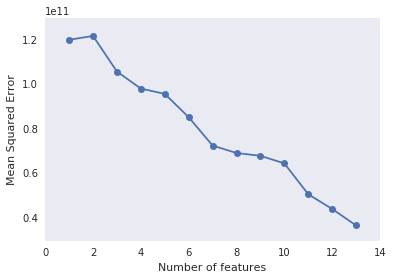

In [12]:
# graficamos
k_feat = [len(k) for k in sbs.subsets_]
plot(k_feat, sbs.scores_, marker='o')
#ylim([0.0, 1.1])
ylabel('Mean Squared Error')
xlabel('Number of features')
grid()
show()

In [13]:
# hacemos una prueba en el set original
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.996987459588
Test accuracy: 0.706410562595


In [14]:
k_param = list(sbs.subsets_[0])
print(properties_caba.iloc[:, properties_caba.columns != 'price'].columns[k_param])

Index(['property_type', 'place_name', 'place_with_parent_names', 'state_name',
       'lat', 'lon', 'surface_total_in_m2', 'surface_covered_in_m2', 'floor',
       'rooms', 'created_on_year', 'created_on_month', 'created_on_day'],
      dtype='object')


In [15]:
# y como clasifica tomando solo los features devueltos
knn.fit(X_train_std[:, k_param], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k_param], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k_param], y_test))

Training accuracy: 0.996987459588
Test accuracy: 0.706410562595


Creo que luego de varias corridas el mejor resultado se da cuando seleccionamos todos los features. Por lo que nos quedamos con este resultado.

# Seleccion de la cantidad optima de vecinos y la metrica a utilizar
Elegimos k usando grid search y luego p usando random search

In [16]:
k_scores = []
k_list = []
p_list = []
labels = []

best_score = 0
best_k = 0
best_p = 0

for i in range(5,14):
    for p in np.random.randint(2,6,size=4):
        knn = KNeighborsRegressor(n_neighbors=i, weights='distance', p=p)
        knn.fit(X_train_std[:, k_param], y_train)

        p_list.append(p)
        k_list.append(i)
        
        sc = knn.score(X_test_std[:, k_param], y_test)
        
        labels.append(str(round(sc,3)))
        k_scores.append(sc)
        
        if(sc > best_score):
            best_score = sc
            best_k = i
            best_p = p

mu = np.mean(k_scores)
v = np.var(k_scores)

k_scores = list(map(lambda x: ((x-mu)/v)*50, k_scores))

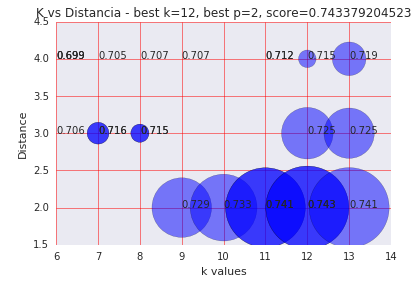

In [17]:
# graficamos
fig, ax = plt.subplots()
ax.scatter(k_list, p_list, s=k_scores, alpha=0.5)

title = "K vs Distancia - best k=%s, best p=%s, score=%s"%(best_k, best_p, best_score)
plt.title(title)
ylabel('Distance')
xlabel('k values')

for i, label in enumerate(labels):
    ax.annotate(label, (k_list[i],p_list[i]))

ax.grid(linestyle='-', linewidth='0.5', color='red')

plt.savefig('/home/jovyan/work/TP/TP2/img/best_k=%s-best_p=%s-score=%s.png'%(best_k, best_p, best_score));

### Corridas con p=2
Primera corrida: p=2 k=5
</br>Corridas posteriores: p=2, k entre 9 y 13

### Corridas modificando tanto p como k
<ul>
<li>p=46, k=3, score=0.93</li>
<li>p=57, k=3, score=0.933</li>
<li>p=4, k=2, score=0.905</li>
<li>p=82, k=4, score=0.89477</li>
<li>p=81, k=5, score=0.8630</li>
<li>p=2, k=6, score=0.9638</li>
</ul>

# Prediccion

In [18]:
# leemos set de test
test_df = pd.read_csv('../data/test/properati_dataset_testing_noprice.csv', low_memory=False)
test_df.head()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,-58.363464,0.0,NaN,NaN,NaN,NaN,Edificio BA Houses situado frente al Dique 3 d...
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,El departamento cuenta con un living-comedor a...
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,-58.412880,53.0,48.0,NaN,NaN,1500,IMPECABLE TORRE COY III – DEPA...
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,NaN,NaN,39.0,39.0,NaN,NaN,NaN,AMBIENTE DIVISIBLE CON PISOS D...
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,NaN,NaN,51.0,51.0,NaN,NaN,NaN,LIVING COMEDOR CON PISOS DE PO...


In [19]:
# transformamos atributos categoricos
test_df['place_name'] = encoder.fit_transform(test_df[['place_name']])
test_df['state_name'] = encoder.fit_transform(test_df[['state_name']])
test_df['place_with_parent_names'] = encoder.fit_transform(test_df[['place_with_parent_names']])
test_df['property_type'] = encoder.fit_transform(test_df[['property_type']])

# tranformamos fechas
X_test_df = knnlibrary.transform_date(test_df)
X_test_df = X_test_df[['floor', 'lat', 'lon', 'place_name', 'place_with_parent_names',
       'property_type', 'rooms', 'state_name', 'surface_covered_in_m2',
       'surface_total_in_m2', 'created_on_year', 'created_on_month',
       'created_on_day']]

# completamos valores nan
from sklearn.preprocessing import Imputer
imputer_mean = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_test_df['floor'] = X_test_df[['floor']].fillna(1)
X_test_df['rooms'] = X_test_df[['rooms']].fillna(1)

X_test_df["surface_total_in_m2"] = imputer_mean.fit_transform(X_test_df[["surface_total_in_m2"]])
X_test_df["surface_covered_in_m2"] = imputer_mean.fit_transform(X_test_df[["surface_covered_in_m2"]])
X_test_df["lat"] = imputer_mean.fit_transform(X_test_df[["lat"]])
X_test_df["lon"] = imputer_mean.fit_transform(X_test_df[["lon"]])

X_test_std_df = stdsc.transform(X_test_df)

X_test_df.head()

/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:20:

,floor,lat,lon,place_name,place_with_parent_names,property_type,rooms,state_name,surface_covered_in_m2,surface_total_in_m2,created_on_year,created_on_month,created_on_day
0,1.0,-34.610988,-58.363464,152,219,1,1.0,4,359.471588,0.0,2017,8,24
1,1.0,-34.629923,-58.465820,29,180,1,1.0,3,359.471588,0.0,2017,8,25
2,1.0,-34.589363,-58.412880,136,210,1,1.0,4,48.000000,53.0,2017,8,1
3,1.0,-34.629923,-58.465820,40,193,1,1.0,4,39.000000,39.0,2017,8,1
4,1.0,-34.629923,-58.465820,40,193,1,1.0,4,51.000000,51.0,2017,8,1


In [20]:
#X_test_std_df.info()

In [21]:
knn = KNeighborsRegressor(n_neighbors=best_k, weights='distance', p=best_p)
knn.fit(X_train_std[:, k_param], y_train)
X_test_df['prediction'] = knn.predict(X_test_std_df)
X_test_df.head(10)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,floor,lat,lon,place_name,place_with_parent_names,property_type,rooms,state_name,surface_covered_in_m2,surface_total_in_m2,created_on_year,created_on_month,created_on_day,prediction
0,1.0,-34.610988,-58.363464,152,219,1,1.0,4,359.471588,0.0,2017,8,24,179178.251994
1,1.0,-34.629923,-58.465820,29,180,1,1.0,3,359.471588,0.0,2017,8,25,178392.138553
2,1.0,-34.589363,-58.412880,136,210,1,1.0,4,48.000000,53.0,2017,8,1,144289.016547
3,1.0,-34.629923,-58.465820,40,193,1,1.0,4,39.000000,39.0,2017,8,1,152892.537102
4,1.0,-34.629923,-58.465820,40,193,1,1.0,4,51.000000,51.0,2017,8,1,186415.938092
5,1.0,-34.629923,-58.465820,40,193,1,1.0,4,39.000000,39.0,2017,8,1,152892.537102
6,1.0,-34.629923,-58.465820,40,193,1,1.0,4,39.000000,39.0,2017,8,1,152892.537102
7,1.0,-34.629923,-58.465820,40,193,1,1.0,4,39.000000,39.0,2017,8,1,152892.537102
8,1.0,-34.578721,-58.457095,47,195,1,1.0,4,67.000000,67.0,2017,8,1,142752.725839
9,1.0,-34.629923,-58.465820,7,184,1,1.0,4,47.000000,47.0,2017,8,1,152491.278098


In [22]:
output = pd.DataFrame( data={"id":test_df["id"], "price_usd":X_test_df['prediction']} )

In [24]:
# ejecutamos knn
output.to_csv( "../data/result/result_"+str(now)+".csv", index=False, quoting=3 )